In [6]:
import sys
from pathlib import Path
project_root = Path.cwd().parents[0]  # importing functions from other folders
sys.path.insert(0, str(project_root))

from _data.data_utils import read_in
import os
from patsy import dmatrix
import numpy as np
from matplotlib import pyplot as plt
import arviz as az

if '___laptop' in os.listdir('../'):
    # laptop folder
    folder = "../../_data/p-dengue/"
elif '___server' in os.listdir('../'):
    # server folder
    folder = "../../../../../data/lucaratzinger_data/p_dengue/"

In [7]:
num_knots = 5
degree = 3

In [8]:
d = np.linspace(0, 1, 1000)
knot_list = np.linspace(np.min(d), np.max(d), num_knots+2)[1:-1]

In [10]:
B = dmatrix(f"bs(s, knots=knots, degree=degree, include_intercept=True)",
                        {"s": np.linspace(np.min(d), np.max(d), 100), "knots": knot_list, "degree":degree})
print(f"B.shape: {B.shape}")

B_full = dmatrix(f"bs(s, knots=knots, degree=degree, include_intercept=True)-1",
                        {"s": np.linspace(np.min(d), np.max(d), 100), "knots": knot_list, "degree":degree})
print(f"B_full.shape: {B_full.shape}")

B_drop = dmatrix(f"bs(s, knots=knots, degree=degree, include_intercept=False)-1",
                        {"s": np.linspace(np.min(d), np.max(d), 100), "knots": knot_list, "degree":degree})
print(f"B_drop.shape: {B_drop.shape}")

B.shape: (100, 10)
B_full.shape: (100, 9)
B_drop.shape: (100, 8)


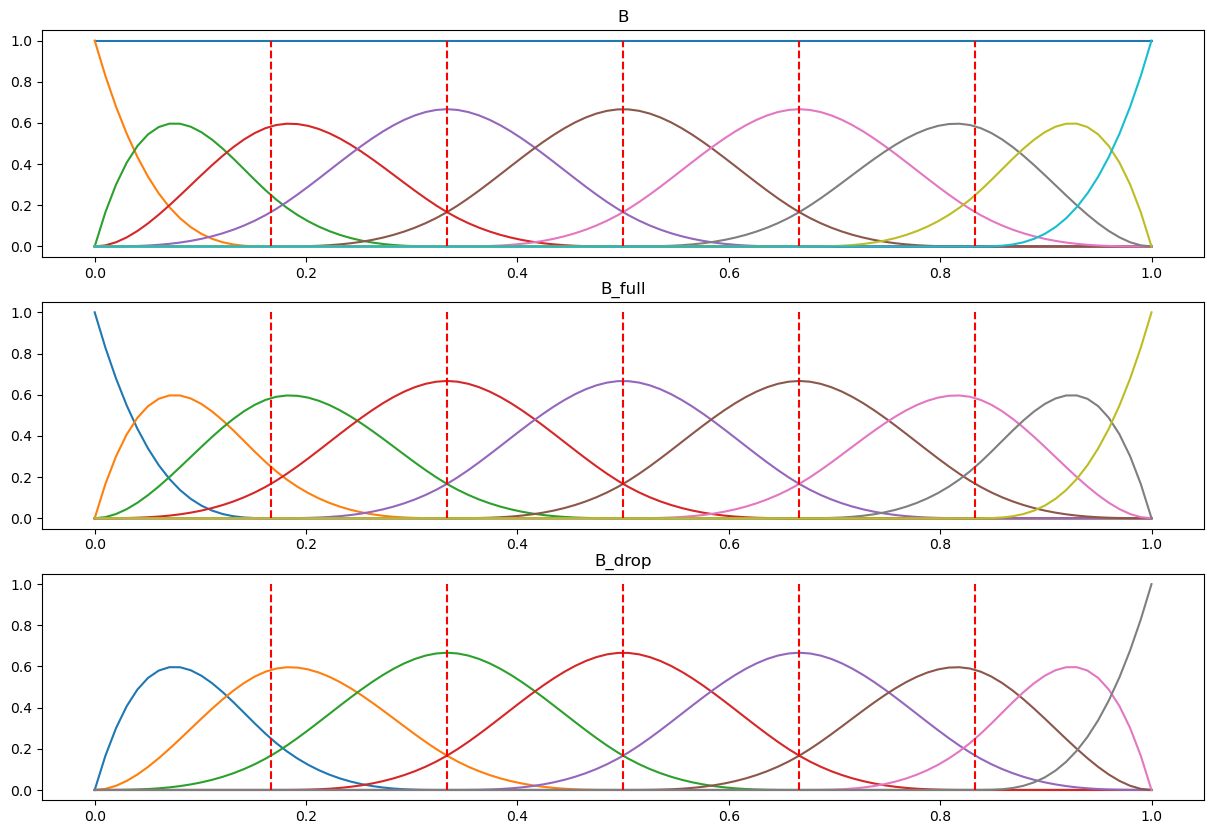

In [13]:
# make 3 subplots for B, B_full and B_drop
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.plot(np.linspace(np.min(d), np.max(d), 100), B[:, :])
plt.vlines(knot_list, ymin=0, ymax=1, color='red', linestyle='--')
plt.title("B")

plt.subplot(3,1,2)
plt.plot(np.linspace(np.min(d), np.max(d), 100), B_full[:, :])
plt.vlines(knot_list, ymin=0, ymax=1, color='red', linestyle='--')
plt.title("B_full")

plt.subplot(3,1,3)
plt.plot(np.linspace(np.min(d), np.max(d), 100), B_drop[:, :])
plt.vlines(knot_list, ymin=0, ymax=1, color='red', linestyle='--')
plt.title("B_drop")
plt.show()

In [ ]:
# Eigenvalues
np.linalg.eig(B.T@B)[0]

array([14.82695819, 10.93791506,  7.24424446,  5.09910418,  3.66150739,
        2.55117893,  1.82537247,  0.58671602,  0.86136371])

In [ ]:
# Be = e
np.linalg.inv(B.T@B)@B.T@np.ones(100)

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

---

In [18]:
data_settings = {'admin':2, 'max_lag':6, 'start_year':2016, 'start_month':1, 'end_year':2019, 'end_month':12}
data = read_in(folder, **data_settings, standardise=True, dropna=True, celsius=True, tp_log=True)
stat_name = 'tp_24hmean_pop_weighted_log(1)'
d = data[stat_name]
d = np.asarray(d)

num_knots = 5
degree = 3

knot_list = np.percentile(d, np.linspace(0, 100, num_knots + 2))[1:-1]
plot_knots = (np.exp(knot_list) - 1e-6) * 1000

In [21]:
B_full=dmatrix(f"bs(s, knots=knots, degree=degree, include_intercept=True)-1",
                        {"s": d, "knots": knot_list, "degree":degree})
B_drop=dmatrix(f"bs(s, knots=knots, degree=degree, include_intercept=False)-1",
                        {"s": d, "knots": knot_list, "degree":degree})

sorted_indices = np.argsort(d)
d = d[sorted_indices]
B_full = B_full[sorted_indices, :]
B_drop = B_drop[sorted_indices, :]

B_full_centred = (B_full - B_full.mean(axis=0))
B_full_std = B_full_centred / B_full.std(axis=0)
B_full_centred_unit = B_full_centred / (np.max(B_full_centred, axis=0) - np.min(B_full_centred, axis=0))

B_drop_centred = (B_drop - B_drop.mean(axis=0))
B_drop_std = B_drop_centred / B_drop.std(axis=0)
B_drop_centred_unit = B_drop_centred / (np.max(B_drop_centred, axis=0) - np.min(B_drop_centred, axis=0))

Q_full, R_full = np.linalg.qr(B_full)
Q_drop, R_drop = np.linalg.qr(B_drop)

Q_full_centred, R_full_centred = np.linalg.qr(B_full_centred)
Q_drop_centred, R_drop_centred = np.linalg.qr(B_drop_centred)

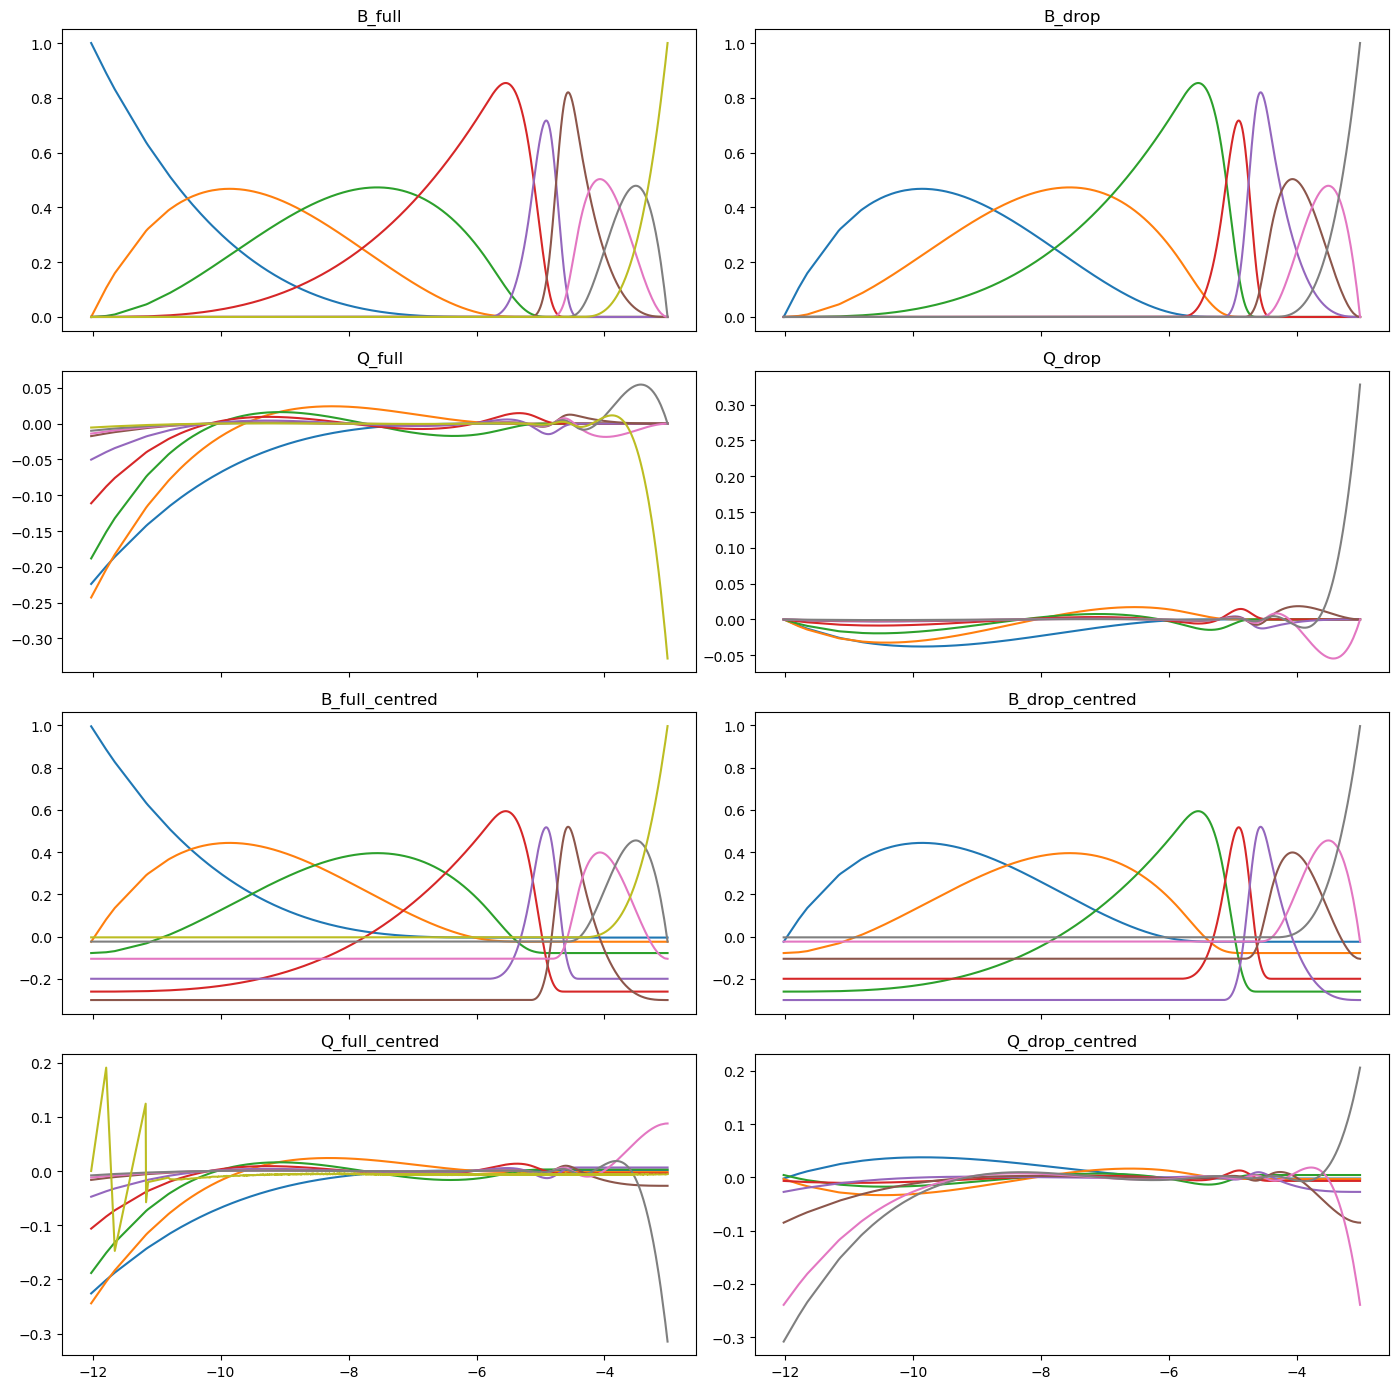

In [28]:
matrices = [
    ("B_full", B_full),
    ("B_drop", B_drop),
    ("Q_full", Q_full),
    ("Q_drop", Q_drop),
    ("B_full_centred", B_full_centred),
    ("B_drop_centred", B_drop_centred),
    ("Q_full_centred", Q_full_centred),
    ("Q_drop_centred", Q_drop_centred),
]

fig, axes = plt.subplots(4, 2, figsize=(14, 14), sharex=True)
axes = axes.ravel()

for ax, (title, mat) in zip(axes, matrices):
    ax.plot(d, mat)
    ax.set_title(title)

for ax in axes[len(matrices):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

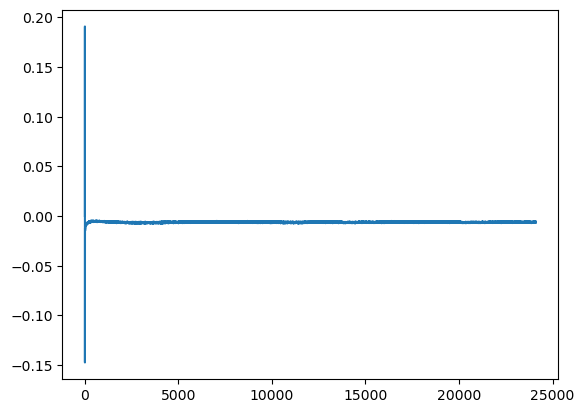

In [29]:
plt.plot(Q_full_centred[:, -1])

The fact that the columns of B_centred sum to zero mean they are not linearly independent, last column of Q is therefore zero but numerical errors cause spike discontinuities.